<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/Trading_Extreme_Spot_Borrow_Rates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lending, Funding and Carry Effects

Two ideas I want to test out.


1. Very extreme lending rates leads to tradeable short squeeze effects 
2. Perpetual futures funding may be exploited as a long/short carry trade.

The first we can look at quickly. 

The second is a little more of a project.

In [85]:
# snippet: rw load rwrtools v0.4

# lists of libraries: rwRtools dependencies (install but don't load) and libs_to_load (install and load)
dependencies <- c(
  "pacman", "ttr", "googleauthr", "doparallel", "googlecloudstorager", 
  "iterators", "R.methodsS3", "openssl", "foreach", "xts", "R.oo", "feather", 
  "R.utils"
)
libs_to_load <- c("tidyverse", "lubridate", "purrr", "stringr", "zoo", "glue", "here", "roll")

# comment out next two lines if not loading rsims
rsims_dependencies <- c("stringr", "lubridate", "roll", "Rcpp")
dependencies <- c(dependencies, rsims_dependencies)

# capitalisation of call to CRAN may not always match capitalisation of package name (eg library(doParallel) vs sudo apt install r-cran-doparallel).
install_from_cran <- gsub("^(?!R\\.)([\\w]+)", "\\L\\1", unique(c(libs_to_load, dependencies)), perl = TRUE)  # convert to lowercase all letters other than an "R" at the start followed by "."

msg1 <- system2('sudo', args = c('apt-get', 'update'),
  stdout = TRUE,
  stderr = TRUE,
  wait = TRUE
)

msg2 <- system2(
  'sudo', 
  args = c('apt', 'install', sub('', 'r-cran-', install_from_cran, '-y --fix-missing')),
  stdout = TRUE,
  stderr = TRUE,
  wait = TRUE
)

pacman::p_load(char = libs_to_load, install = FALSE)

# install and load rwRtools from GH (sans dependencies)
pacman::p_load_current_gh("RWLab/rwRtools", dependencies = FALSE)

# install and load rsims from GH (sans dependencies)
# pacman::p_load_current_gh("Robot-Wealth/rsims", dependencies = FALSE)

# output messages from install - optional, for debugging
# msg

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

# What data do we want?

* Spot prices
* Spot lending rates
* Perp prices
* Perp funding rates

In [86]:
rwlab_data_auth()

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/auth?client_id=603366585132-0l5tra7gl2i20iftqangp7iskte4f3s0.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code



Enter authorization code: 4/1AdQt8qgamki3wHpCYVL4XBk667ytb443z4sxyr80i6-Rq4fWSoLbq40P_Wc


In [87]:
#' Get Spot Markets v0.1
#' 
#' @description Get metadata for spot markets
#'
#' @return dataframe of spot markets API call was successful, otherwise call result
#' @export
#'
#' @examples
#' get_spot_markets()

get_ftx_spot_markets <- function() {

  # Get markets
  endpoint <- "https://ftx.com/api/markets"
  res <- httr::GET(endpoint) 
    
  res_json <- res$content %>% 
    rawToChar() %>% 
    jsonlite::fromJSON()
    
  if(res_json$success == TRUE) {
    markets <- res_json %>% 
      purrr::pluck("result") %>% 
      filter(
        type == 'spot',
        is.na(tokenizedEquity),
        quoteCurrency == 'USD',
        !grepl('HEDGE|BEAR|BULL|HALF', baseCurrency),
        !baseCurrency %in% c('USD','USDT','BVOL','IBVOL','DAI','EUR','GBP','WBTC','STETH','MSOL'), # TODO - get rid of more stuff 
      )
      
    return(markets)
  } else {
    print("Request failed.")
      
    return(res_json)
  }

}

spot_markets <- get_ftx_spot_markets() 

spot_markets %>% head()

,name,enabled,postOnly,priceIncrement,sizeIncrement,minProvideSize,last,bid,ask,price,⋯,highLeverageFeeExempt,largeOrderThreshold,change1h,change24h,changeBod,quoteVolume24h,volumeUsd24h,priceHigh24h,priceLow24h,tokenizedEquity
,<chr>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,1INCH/USD,TRUE,FALSE,1e-04,1.000,1.000,0.621400,0.62110,0.6220,0.62140,⋯,TRUE,350,-0.011925584,0.015359477,-0.020800504,299606.885,299606.885,0.63690,0.60360,NA
2,AAVE/USD,TRUE,FALSE,1e-02,0.010,0.010,79.530000,79.36000,79.4100,79.41000,⋯,TRUE,1200,-0.011821802,-0.005385772,-0.017567735,2259517.502,2259517.502,82.88000,76.47000,NA
3,AGLD/USD,TRUE,FALSE,5e-04,0.100,0.100,0.429000,0.42850,0.4300,0.42900,⋯,TRUE,350,0.032490975,0.034981906,0.037484885,94282.110,94282.110,0.42950,0.39950,NA
4,AKRO/USD,TRUE,FALSE,5e-06,1.000,1.000,0.004665,0.00467,0.0047,0.00467,⋯,TRUE,350,0.001071811,0.006465517,-0.004264392,2478.667,2478.667,0.00475,0.00459,NA
5,ALCX/USD,TRUE,FALSE,1e-01,0.001,0.001,24.500000,24.50000,24.6000,24.50000,⋯,TRUE,350,-0.012096774,-0.016064257,-0.020000000,27373.340,27373.340,25.10000,23.90000,NA
6,ALEPH/USD,TRUE,FALSE,5e-05,1.000,1.000,0.261900,0.26120,0.2619,0.26190,⋯,TRUE,350,0.000000000,0.000190949,0.000000000,14628.326,14628.326,0.26225,0.26100,NA


In [88]:
# snippet: load FTX spot data v0.1
spot <- rwRtools::crypto_get_spot()

spot %>% summarise(
  min_date = min(date), 
  max_date = max(date)
)


# snippet: rw crypto load ftx lending data v0.1
lending_rates <- rwRtools::crypto_get_lending_rates()

lending_rates %>% 
  summarise(
    min_date = min(date), 
    max_date = max(date)
  )

# snippet: rw crypto load ftx futures v0.1
futures <- rwRtools::crypto_get_futures()

futures %>% 
  summarise(
    min_date = min(date), 
    max_date = max(date)
  )

# snippet: rw crypto load ftx perpetual funding rates v0.1
perp_rate <- rwRtools::crypto_get_perp_rates()

perp_rate %>%
  summarise(
    min_date = min(date), 
    max_date = max(date)
  )

ℹ Downloading ftx_spot_ohlc_1h.feather

✔ Saved ftx_spot_ohlc_1h.feather to ftx/ftx_spot_ohlc_1h.feather  ( 653.1 Mb )





File successfully transferred


min_date,max_date
<dttm>,<dttm>
2019-07-21 13:00:00,2022-07-26 03:00:00


ℹ Downloading ftx_coin_lending_rates.feather

✔ Saved ftx_coin_lending_rates.feather to ftx/ftx_coin_lending_rates.feather  (…





File successfully transferred


min_date,max_date
<dttm>,<dttm>
2020-11-26 08:00:00,2022-07-26 04:00:00


ℹ Downloading ftx_futures_ohlc_1h.feather

✔ Saved ftx_futures_ohlc_1h.feather to ftx/ftx_futures_ohlc_1h.feather  ( 196.1…





File successfully transferred


min_date,max_date
<dttm>,<dttm>
2019-07-20 12:00:00,2022-07-26 02:00:00


ℹ Downloading ftx_perpetual_funding_rates.feather

✔ Saved ftx_perpetual_funding_rates.feather to ftx/ftx_perpetual_funding_rates.…





File successfully transferred


min_date,max_date
<dttm>,<dttm>
2019-03-06 15:00:00,2022-07-26 02:00:00


# How to the observations align?

In [89]:
spot %>% head()

ticker,date,open,high,low,close,volume
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1INCH/USD,2020-12-25 05:00:00,2.3956,2.9716,2.30955,2.5893,53413.45
1INCH/USD,2020-12-25 06:00:00,2.5893,2.6400,2.22560,2.5190,58925.92
1INCH/USD,2020-12-25 07:00:00,2.5190,2.8000,2.34990,2.6067,87704.12
1INCH/USD,2020-12-25 08:00:00,2.6067,2.7750,2.48290,2.6019,89654.50
1INCH/USD,2020-12-25 09:00:00,2.6019,2.7600,2.48210,2.6739,42066.59
1INCH/USD,2020-12-25 10:00:00,2.6739,2.9591,2.65150,2.7959,69676.92


In [90]:
spot %>%
  group_by(ticker) %>%
  summarize(n()) %>%
  arrange(ticker)

ticker,n()
<chr>,<int>
1INCH/USD,13871
AAPL/USD,15135
AAVE/USD,15650
AAVE/USDT,15650
ABNB/USD,14256
ACB/USD,14081
ADABEAR/USD,23919
ADABULL/USD,24137
ADAHALF/USD,20011


In [91]:
lending_rates %>%
  head()

ticker,date,size,rate
<chr>,<dttm>,<dbl>,<dbl>
1INCH,2021-01-08 20:00:00,0.0000,1.000e-06
1INCH,2021-01-08 21:00:00,52.0000,5.710e-06
1INCH,2021-01-08 22:00:00,156.0004,2.283e-05
1INCH,2021-01-08 23:00:00,317.1501,2.283e-05
1INCH,2021-01-09 00:00:00,161.1490,2.283e-05
1INCH,2021-01-09 01:00:00,161.1530,2.283e-05


We want to join our data on ticker and datetime 

In [93]:
spot %>%
  filter(ticker %in% c(pull(spot_markets, name), 'LUNC/USD')) %>%
  mutate(ticker = sub("\\/.*", "", ticker)) %>%
  inner_join(lending_rates, by = c('ticker','date')) %>%
  head()


ticker,date,open,high,low,close,volume,size,rate
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1INCH,2021-01-08 20:00:00,1.2058,1.2128,1.1484,1.1571,1035.4362,0.0000,1.000e-06
1INCH,2021-01-08 21:00:00,1.1571,1.1860,1.1394,1.1857,273.1195,52.0000,5.710e-06
1INCH,2021-01-08 22:00:00,1.1857,1.2194,1.1689,1.2131,2112.7212,156.0004,2.283e-05
1INCH,2021-01-08 23:00:00,1.2131,1.2183,1.1952,1.1952,13880.9193,317.1501,2.283e-05
1INCH,2021-01-09 00:00:00,1.1952,1.2121,1.1285,1.1428,56093.2731,161.1490,2.283e-05
1INCH,2021-01-09 01:00:00,1.1428,1.1512,1.1142,1.1428,3202.9001,161.1530,2.283e-05


Calculate returns from:
 * price change
 * lending spot

In [94]:
lending_analysis <- spot %>%
  filter(ticker %in%  c(pull(spot_markets, name), 'LUNC/USD')) %>%
  mutate(ticker = sub("\\/.*", "", ticker)) %>%
  inner_join(lending_rates, by = c('ticker','date')) %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
      price_change = log(close/lag(close)),
      lending_accrual = lead(rate)
  ) %>% 
  na.omit() %>%
  ungroup()


lending_analysis %>%
  arrange(ticker, date) %>% head()

ticker,date,open,high,low,close,volume,size,rate,price_change,lending_accrual
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1INCH,2021-01-08 21:00:00,1.1571,1.1860,1.1394,1.1857,273.1195,52.0000,5.710e-06,0.02441644,2.283e-05
1INCH,2021-01-08 22:00:00,1.1857,1.2194,1.1689,1.2131,2112.7212,156.0004,2.283e-05,0.02284575,2.283e-05
1INCH,2021-01-08 23:00:00,1.2131,1.2183,1.1952,1.1952,13880.9193,317.1501,2.283e-05,-0.01486553,2.283e-05
1INCH,2021-01-09 00:00:00,1.1952,1.2121,1.1285,1.1428,56093.2731,161.1490,2.283e-05,-0.04483214,2.283e-05
1INCH,2021-01-09 01:00:00,1.1428,1.1512,1.1142,1.1428,3202.9001,161.1530,2.283e-05,0.00000000,2.283e-05
1INCH,2021-01-09 02:00:00,1.1428,1.1578,1.1415,1.1571,2007.9723,161.1571,2.283e-05,0.01243548,2.283e-05


Plot the distribution of lending rates

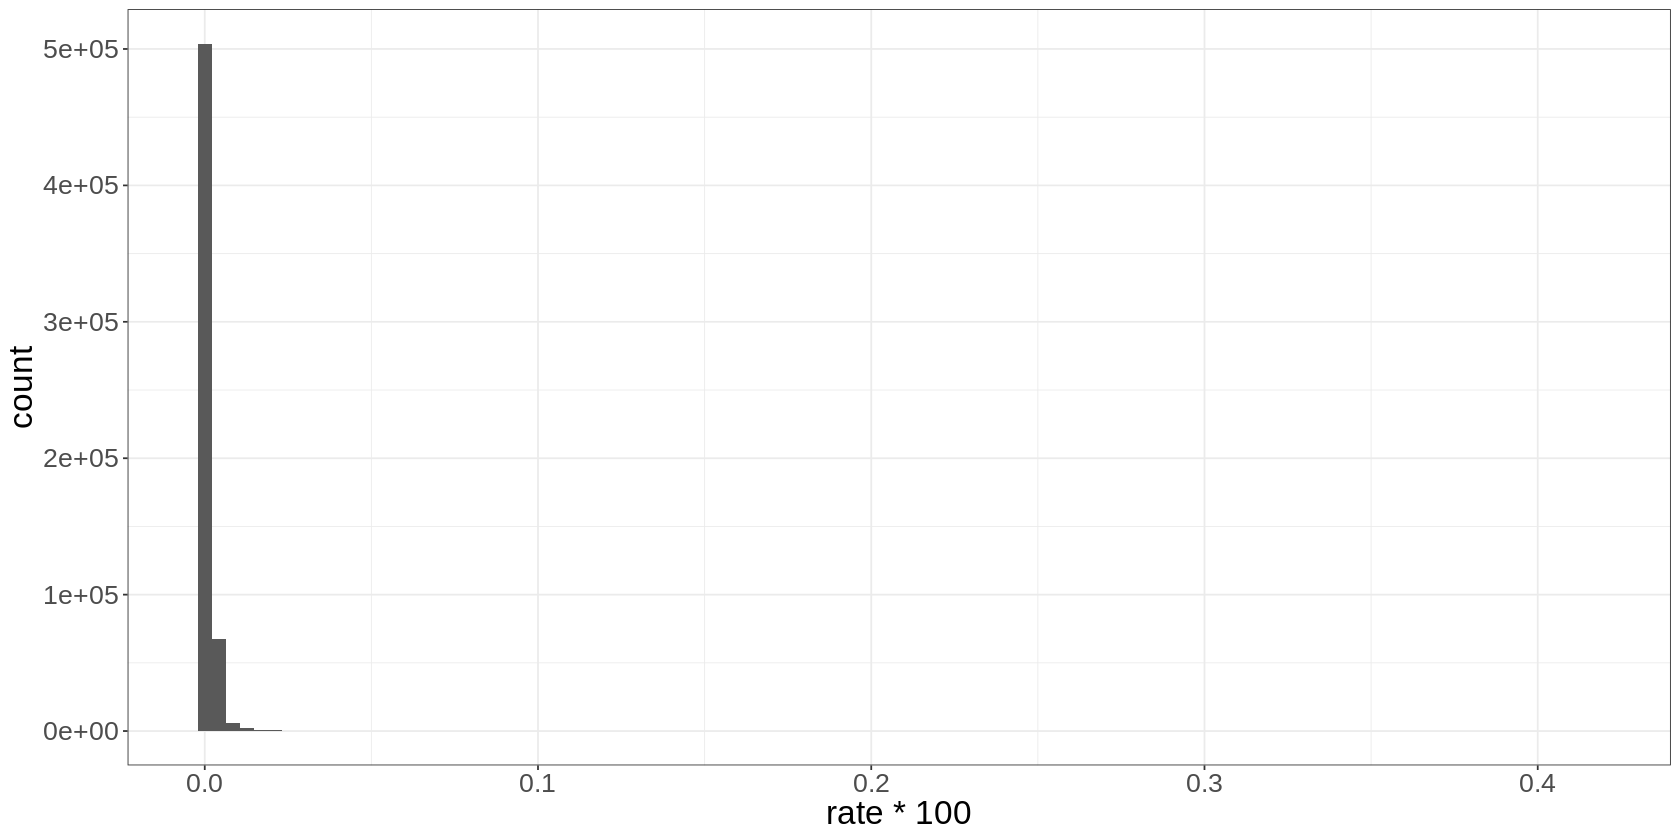

In [95]:
lending_analysis %>%
  ggplot(aes(x=rate*100)) + geom_histogram(bins=100)

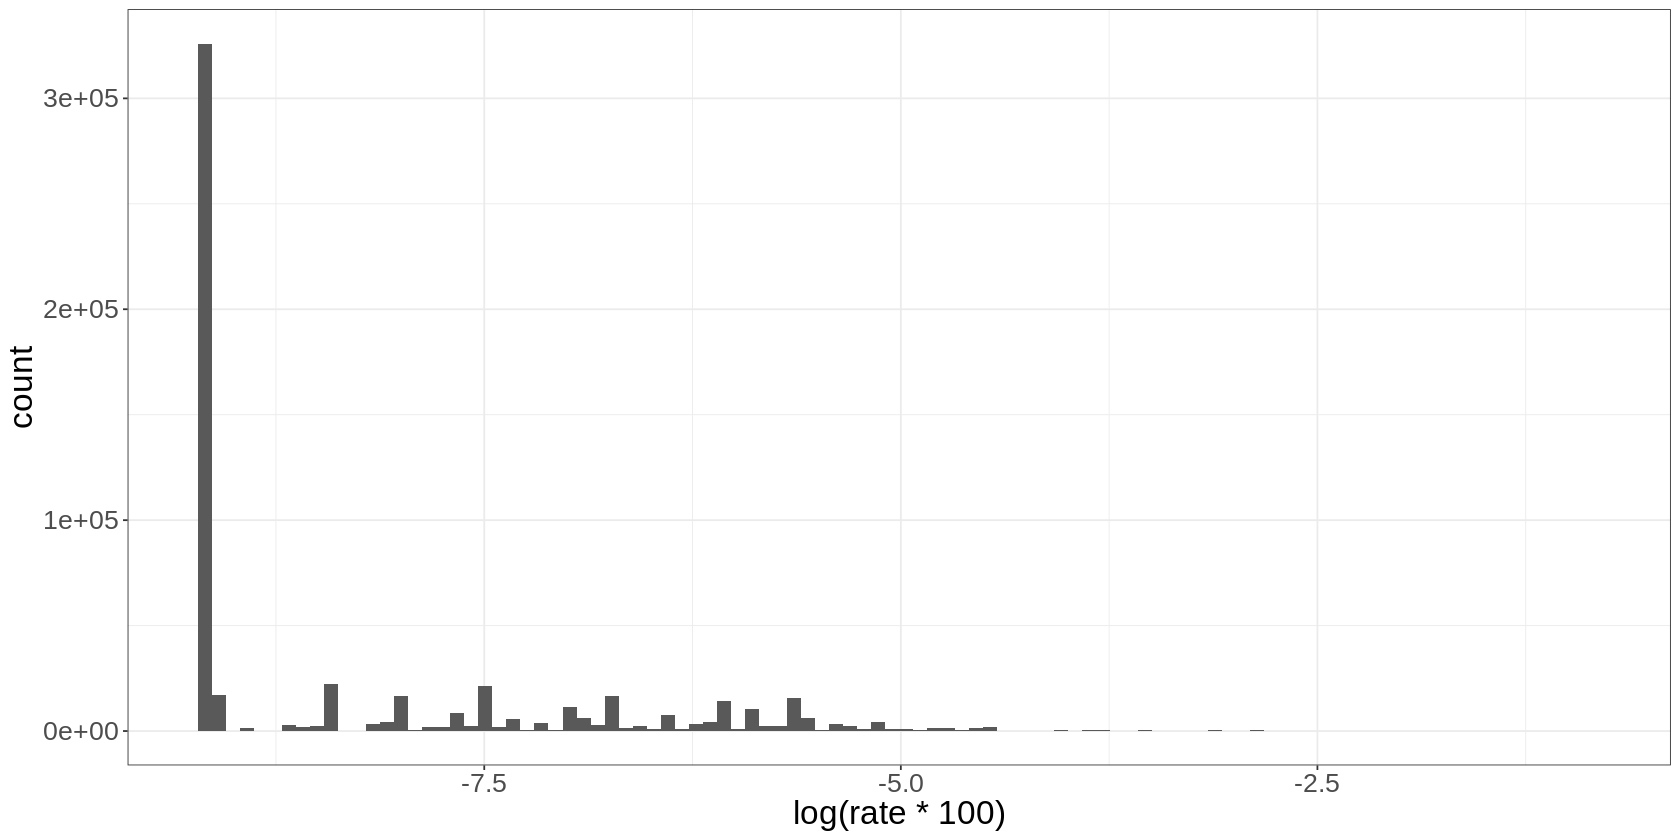

In [96]:
lending_analysis %>%
  ggplot(aes(x=log(rate*100))) + geom_histogram(bins=100)

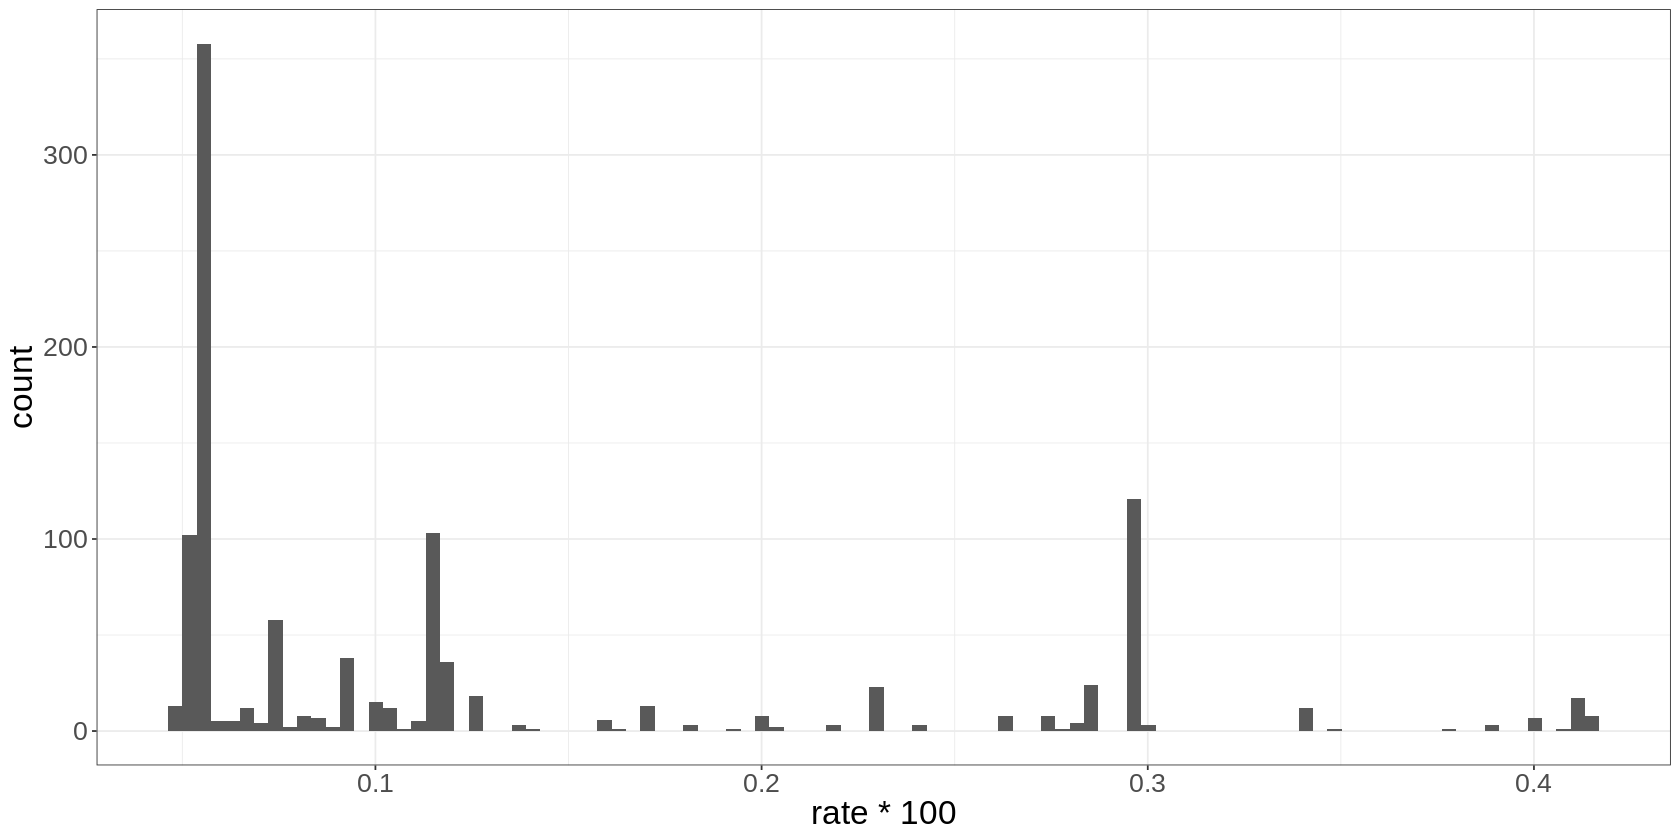

In [97]:
lending_analysis %>%
  filter(rate >= 0.05/100) %>%
  ggplot(aes(x=rate*100)) + geom_histogram(bins=100)

Let's do something very simple. 

Rank it into percentiles and plot mean returns for each percentile. We expect to see positive returns at the extreme right end.

In [98]:
lending_analysis %>% head()

ticker,date,open,high,low,close,volume,size,rate,price_change,lending_accrual
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BCH,2020-11-26 09:00:00,272.5500,278.900,2.7130e+02,2.78225e+02,76694.223,0.00000,1.500e-05,0.020608055,1.500e-05
BTC,2020-11-26 09:00:00,16829.0000,17112.000,1.6678e+04,1.70450e+04,10527879.014,15.66521,4.795e-05,0.012753317,5.000e-04
ETH,2020-11-26 09:00:00,498.2600,507.440,4.9330e+02,5.03650e+02,3345171.373,18.83886,5.000e-05,0.010759553,5.000e-05
LTC,2020-11-26 09:00:00,74.4700,75.440,7.3570e+01,7.47600e+01,8252.022,0.00000,1.000e-06,0.003886623,1.000e-06
XRP,2020-11-26 09:00:00,0.4992,0.523,4.9725e-01,5.18875e-01,149127.194,0.00000,2.000e-04,0.038656189,5.710e-06
BCH,2020-11-26 10:00:00,278.2250,280.550,2.7580e+02,2.80550e+02,8161.233,0.00000,1.500e-05,0.008321823,1.712e-05


Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


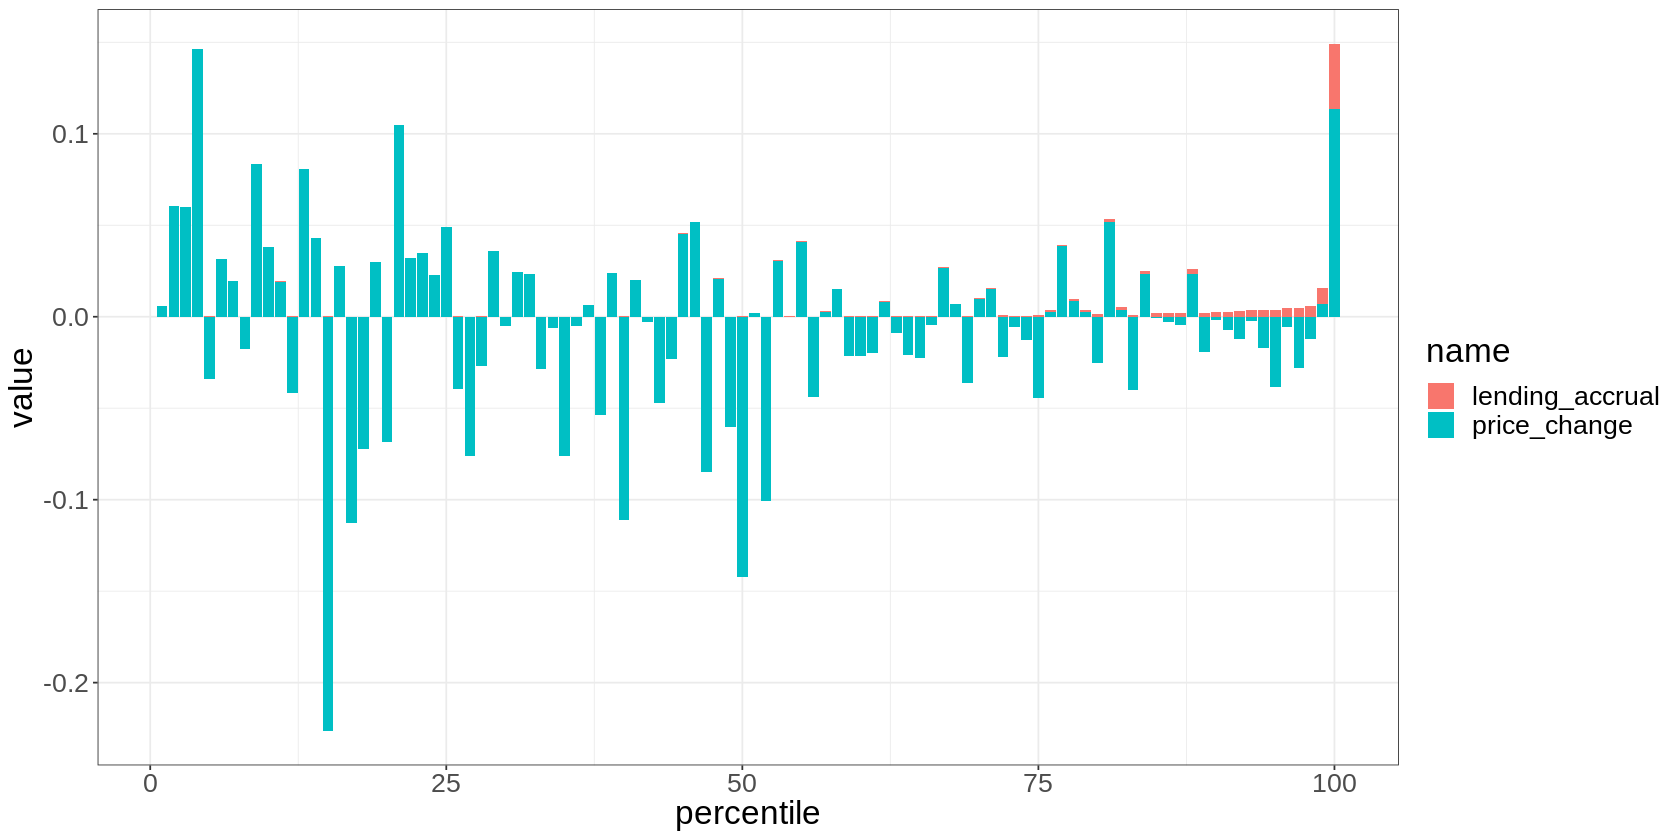

In [99]:
lending_analysis %>% 
  ungroup() %>%
  mutate(percentile = ntile(rate, 100)) %>%
  group_by(percentile) %>%
  summarize(
    price_change = mean(price_change) * 100,
    lending_accrual = mean(lending_accrual) * 100,
    total_returns = price_change + lending_accrual
  ) %>% 
  pivot_longer(c(-percentile, -total_returns)) %>%
  ggplot(aes(x=percentile, y=value, fill=name)) + geom_histogram(stat='identity')

And that's what we seem to seee. Let's make it more extreme.

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


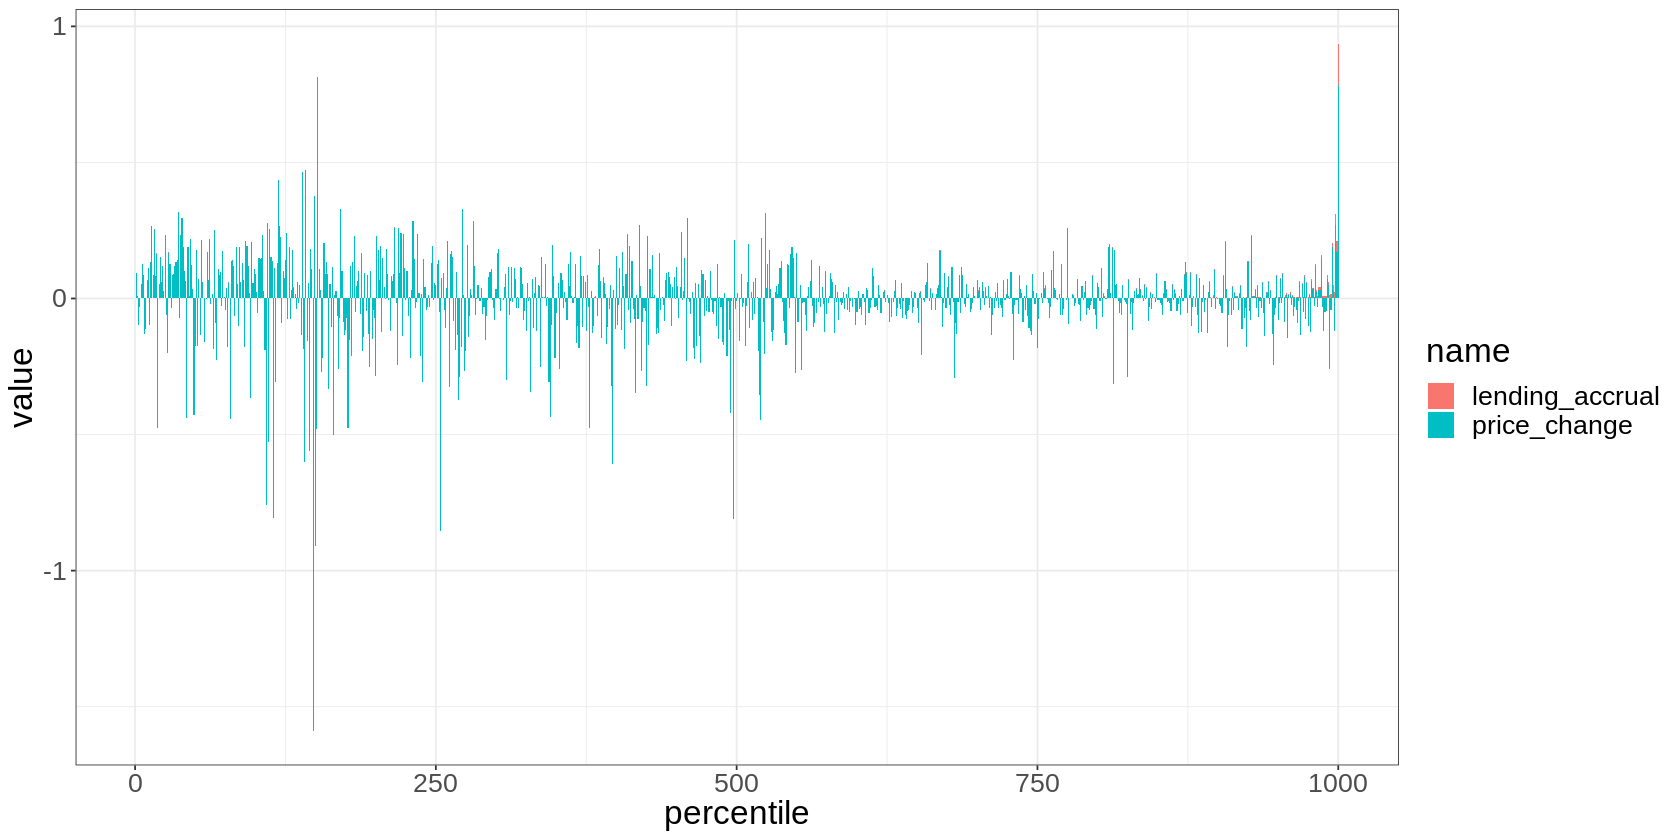

In [100]:
lending_analysis %>% 
  ungroup() %>%
  mutate(percentile = ntile(rate, 1000)) %>%
  group_by(percentile) %>%
  summarize(
    price_change = mean(price_change) * 100,
    lending_accrual = mean(lending_accrual) * 100,
    total_returns = price_change + lending_accrual
  ) %>% 
  pivot_longer(c(-percentile, -total_returns)) %>%
  ggplot(aes(x=percentile, y=value, fill=name)) + geom_histogram(stat='identity')

Again, we see it right in the extreme values.

In [101]:
lending_analysis %>% 
  ungroup() %>%
  mutate(percentile = ntile(rate, 500)) %>%
  group_by(percentile) %>%
  summarize(
    minrate = min(rate) * 100,
    maxrate = max(rate) * 100
  ) %>%
  filter(percentile >= 490)

percentile,minrate,maxrate
<int>,<dbl>,<dbl>
490,0.006138,0.006849
491,0.006849,0.007990
492,0.007990,0.008562
493,0.008562,0.009132
494,0.009132,0.010274
495,0.010274,0.011187
496,0.011187,0.011416
497,0.011416,0.017009
498,0.017009,0.022831


We're really looking at an effect in really extreme funding rates. 

## Hack Backtest

Let's do a hack backestt

Our 500 cutoff was about 0.05% - let's start there.

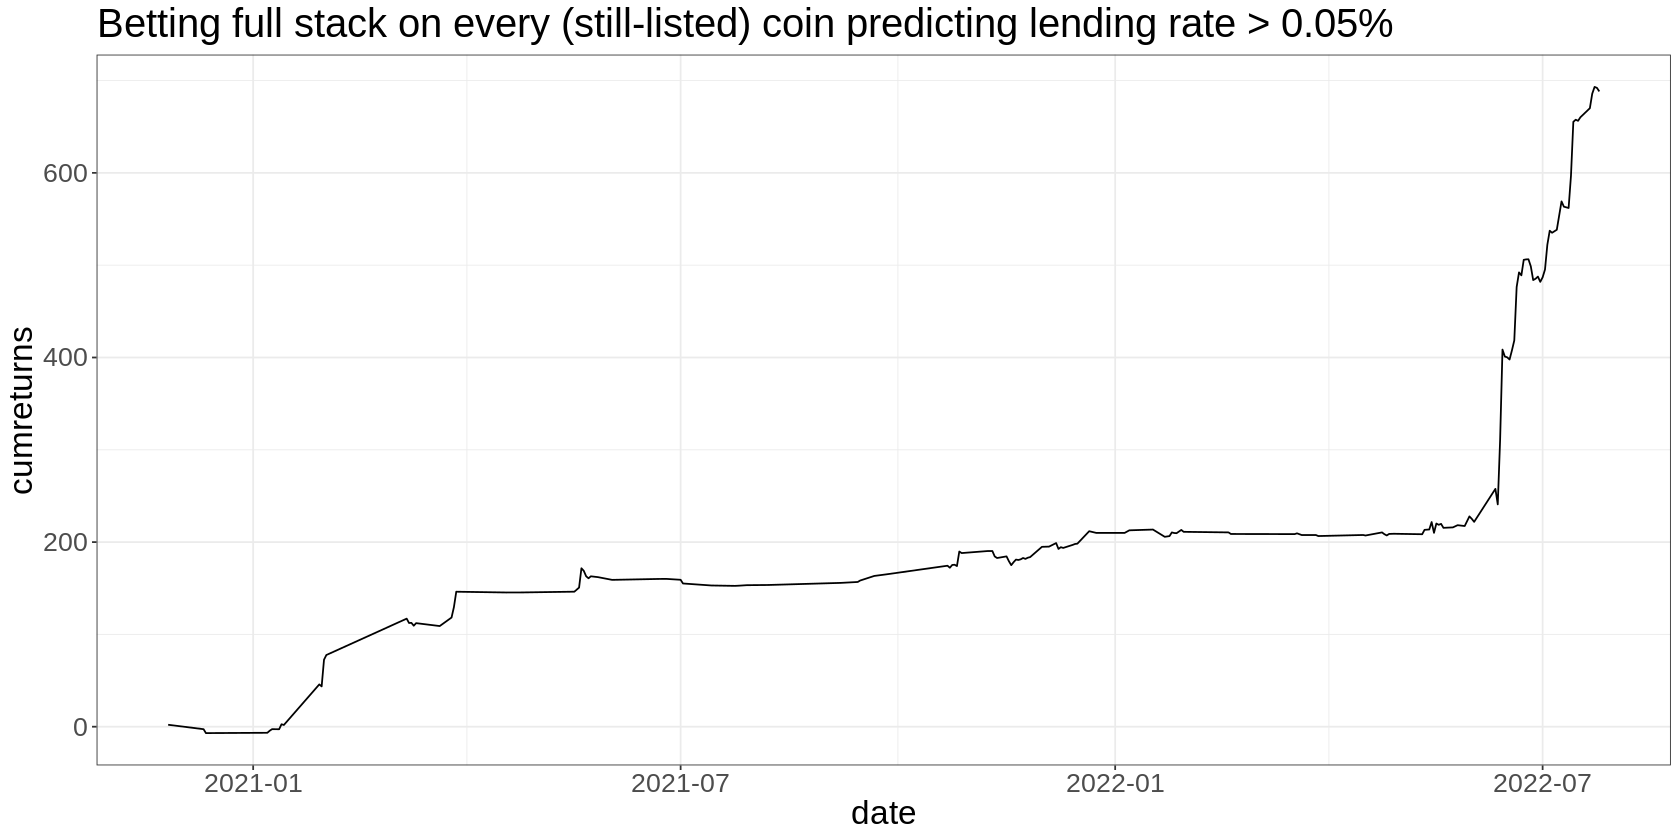

In [105]:
cutoff_pct <- 0.05

lending_analysis %>%
  filter(rate >= cutoff_pct / 100) %>%
  mutate(date = as_date(date)) %>%
  group_by(date) %>%
  summarize(
    price_change = sum(price_change) * 100,
    lending_accrual = sum(lending_accrual) * 100
  ) %>%
  mutate(cumreturns = cumsum(price_change + lending_accrual)) %>%
  ggplot(aes(x=date, y=cumreturns)) + geom_line() + ggtitle('Betting full stack on every (still-listed) coin predicting lending rate > 0.05%')

In [106]:
cutoff_pct <- 0.05

lending_analysis %>%
  filter(rate >= cutoff_pct / 100) %>%
  group_by(ticker) %>%
  summarize(
    price_change = sum(price_change) * 100,
    lending_accrual = sum(lending_accrual) * 100,
    total_return  = price_change + lending_accrual,
    hours = n()
  ) %>%
  arrange(-total_return)

ticker,price_change,lending_accrual,total_return,hours
<chr>,<dbl>,<dbl>,<dbl>,<int>
CEL,375.43329203,67.532852,442.9661440,358
DOGE,73.41103784,1.307064,74.7181018,17
TOMO,32.87568423,5.675639,38.5513232,44
MOB,33.83572876,4.458396,38.2941248,17
1INCH,30.59149605,3.477017,34.0685130,65
ASD,25.35596021,3.040995,28.3969552,52
OKB,13.90161852,6.357705,20.2593235,174
REN,13.12133163,0.364155,13.4854866,2
KNC,7.57171049,0.602168,8.1738785,11


Mostly CEL. But a range of names.

Tentatively.... your strategy is something like:

 - when predicted lending rates > 500%, long.

Anxieties:
 - Would you end up systematically longing a car crash? What to do about that?
 - Receiving the lending interested (by lending your spot) is kinda self-defeating.


 So what doess it look like if we don't lend spot?

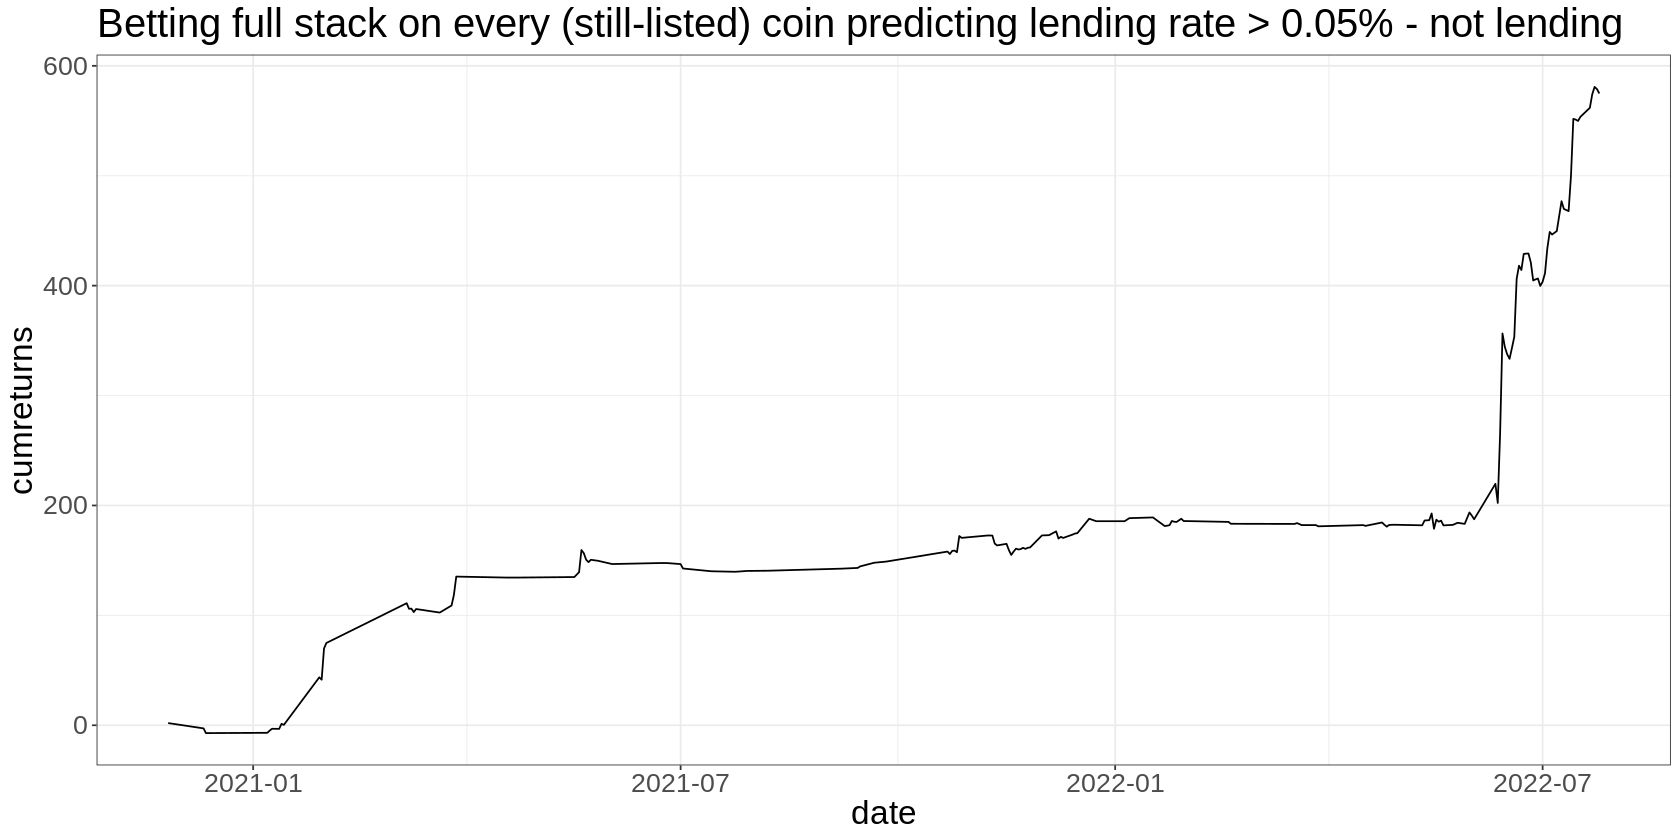

In [114]:
cutoff_pct <- 0.05

lending_analysis %>%
  filter(rate >= cutoff_pct / 100) %>%
  mutate(date = as_date(date)) %>%
  group_by(date) %>%
  summarize(
    price_change = sum(price_change) * 100,
    lending_accrual = sum(lending_accrual) * 100
  ) %>%
  mutate(cumreturns = cumsum(price_change)) %>%
  ggplot(aes(x=date, y=cumreturns)) + geom_line() + ggtitle('Betting full stack on every (still-listed) coin predicting lending rate > 0.05% - not lending')

Interesting to look at:
 * trading the perp long <-- we can look this with the data we have.
 * stuff that shit the bed <- we need to get delisted data (from tardis? or just don't use the markets list?)

I'll have a quick look at these things if it's easy. 

If not, we'll outline sensible "eat shit" rules for actually trading this kind of thing.


# Very brief look at carry effects

Before we wrap up, a very quick look at broad carry effects.

In [109]:
carry_analysis <- futures %>%
  inner_join(perp_rate, by=c('ticker','date')) %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
      price_returns = log(close/lag(close)),
      rate_returns = lead(rate),
      total_returns = price_returns - rate_returns
  ) %>% 
  na.omit()

  carry_analysis %>% head()

ticker,date,open,high,low,close,volume,rate,price_returns,rate_returns,total_returns
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ALGO-PERP,2019-07-20 13:00:00,0.7161,0.7257,0.7014,0.7054,2.657606e+03,0.000003,-0.0150548042,-0.000011,-0.0150438042
ALT-PERP,2019-07-20 13:00:00,764.8000,775.5000,760.5000,763.9000,0.000000e+00,0.000010,-0.0011774712,0.000007,-0.0011844712
BCH-PERP,2019-07-20 13:00:00,316.2000,321.1500,312.2000,314.8500,8.144407e+02,-0.000108,-0.0042785898,-0.000126,-0.0041525898
BNB-PERP,2019-07-20 13:00:00,30.6250,30.8675,30.3350,30.5625,1.649716e+05,0.000054,-0.0020429016,0.000030,-0.0020729016
BSV-PERP,2019-07-20 13:00:00,167.1000,173.3800,166.6000,168.1200,7.331051e+04,0.000009,0.0060855745,0.000005,0.0060805745
BTC-PERP,2019-07-20 13:00:00,10539.5000,10796.2500,10477.0000,10548.7500,2.361670e+07,-0.000003,0.0008772658,0.000003,0.0008742658


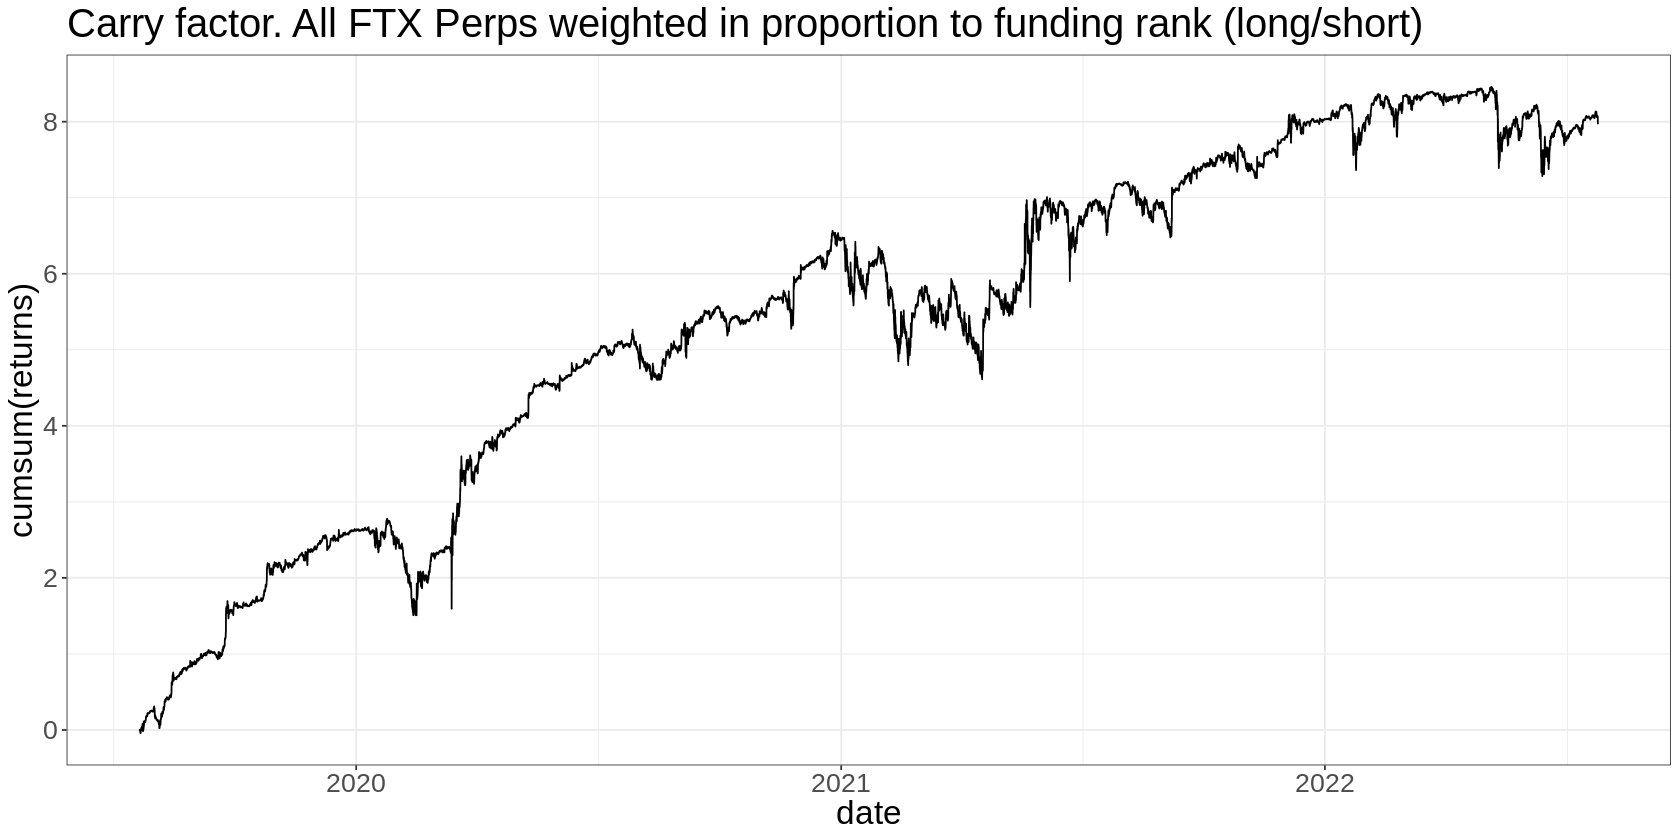

In [115]:
carry_analysis %>%
  mutate(carry = -roll_mean(rate, 24)) %>%
  mutate(
      weight = ntile(carry, 10) - 5.5,
      total_returns = total_returns * weight 
  ) %>%
  na.omit() %>%
  group_by(date) %>%
  summarize(returns = mean(total_returns)) %>% 
  ggplot(aes(x=date, y=cumsum(returns))) + geom_line() + ggtitle('Carry factor. All FTX Perps weighted in proportion to funding rank (long/short)')

Evidence of a noisy carry effect. 

We'll follow up on this in the next session.